In [2]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [3]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *
from utils.detectron2helper import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



HACKING: overriding COCOeval.summarize = vin_summarize...


In [4]:
iou_thr_dfs = pickle.load(open(str(base_dir / 'iou_thr_dfs-11.pkl'), 'rb'))

In [5]:
target_models = [
    'faster_rcnn_R_101_FPN_3x_mkf_5_1024',
    'faster_rcnn_R_50_FPN_3x_mkf_5_1024',
    'faster_rcnn_R_50_FPN_3x_mkf_5_1024_hmean',
    'retinanet_R_101_FPN_3x_mkf_5_1024',
    'retinanet_R_50_FPN_3x_mkf_5_1024',
]

classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [6]:
N_SPLITS = 5
RM = False

In [7]:
def nms_prediction(pred_df:pd.DataFrame, iou_thr_df: pd.DataFrame, cls_nms: List[str], img_size: int):
    records = {'image_id': list(), 'PredictionString': list()}

    for i in tqdm(range(len(pred_df))):
        image_id, f_pred_str = pred_df.loc[i]
        boxes, labels, scores = list(), list(), list()

        objs = np.array(f_pred_str.split(' ')).reshape(-1, 6)
        f_boxes = objs[:, 2:].astype(float)
        f_boxes[:, [0, 2]] /= img_size
        f_boxes[:, [1, 3]] /= img_size
        f_labels = objs[:, 0].astype(int)
        f_scores = objs[:, 1].astype(float)
        
        for cls_id, cls_nm in enumerate(cls_nms):
            if (f_labels == cls_id).sum() == 0:
                continue
            
            cls_nm_df, iou_thr = iou_thr_df.loc[cls_id, ['cls_nm', 'iou_thr']]
            assert cls_nm == cls_nm_df
            
            c_boxes, c_scores, c_labels = nms_by_class(
                boxes=f_boxes,
                scores=f_scores,
                labels=f_labels,
                cls_id=cls_id,
                iou_thr=iou_thr,
                skip_box_thr=0.,
            )

            c_boxes = np.array(c_boxes)
            c_boxes[:, [0, 2]] *= img_size
            c_boxes[:, [1, 3]] *= img_size

            boxes += c_boxes.tolist()
            scores += c_scores.tolist()
            labels += c_labels.tolist()

        pred_str = list()
        for label, score, box in zip(labels, scores, boxes):
            pred_str += [str(int(label))] + [str(score)] + np.array(box).astype(str).tolist()

        records['image_id'] += [image_id]
        records['PredictionString'] += [' '.join(pred_str)]

    return pd.DataFrame(records)


from ensemble_boxes import *

def nms_by_class(
    boxes: np.ndarray, scores: np.ndarray, labels: np.ndarray, cls_id: int, iou_thr: float, skip_box_thr: float
) -> Tuple[List[List[float]], List[float], List[int]]:
    
    mask = (labels == cls_id)
    if mask.sum() == 1:
        return boxes[mask, :], scores[mask], labels[mask]
    else:
        return nms(
            [boxes[mask, :].tolist()],
            [scores[mask].tolist()],
            [labels[mask].tolist()],
            weights=None, 
            iou_thr=iou_thr,
        )

In [58]:
pred_dfs = dict()

for model_dir in tqdm(sorted(iou_thr_dfs.keys())):
    if model_dir in target_models:
        continue
    print(model_dir)
    if '512' in model_dir:
        img_size = 512
    else: 
        img_size = 1024
    
    pred_dfs[model_dir] = list()
    for fold in range(N_SPLITS):
        outdir = base_dir / 'detectron2_results' / model_dir / f'fold-{fold + 1}'
        
        pre_pred_df = pd.read_csv(str(outdir / 'validation.csv'))
        
        post_pred_df = nms_prediction(pre_pred_df, iou_thr_dfs[model_dir], classes_nms, img_size)
        post_pred_df.to_csv(str(outdir / 'validation_nms.csv'))

  0%|          | 0/11 [00:00<?, ?it/s]

cascade_mask_rcnn_R_50_FPN_3x_mkf_5_1024_rm


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/883 [00:00<?, ?it/s]

faster_rcnn_R_101_FPN_3x_mkf_5_1024_rm


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/883 [00:00<?, ?it/s]

retinanet_R_101_FPN_3x_mkf_5_1024_rm


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/883 [00:00<?, ?it/s]

retinanet_R_50_FPN_3x_nms01_mkf_5_512


  0%|          | 0/882 [00:00<?, ?it/s]

  0%|          | 0/905 [00:00<?, ?it/s]

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/870 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]

In [8]:
def check_image_id(df):
    image_ids = df[[c for c in df.columns if 'image_id' in c]].values
    return np.all(list(map(lambda x: len(list(set(x))) == 1, image_ids)))

In [88]:
target_models_512 = [tm for tm in target_models if '512' in tm]
stack_folds_512 = list()

for fold in range(N_SPLITS):
    stack = list()
    for model_dir in tqdm(sorted(iou_thr_dfs.keys())):
        if model_dir not in target_models_512:
            continue
        print(model_dir)
        pred_df = pd.read_csv(str(base_dir / 'detectron2_results' / model_dir / f'fold-{fold + 1}' / 'validation_nms.csv'), index_col=0)
        pred_df = pred_df.rename(columns={c: f'{c}_{model_dir}' for c in pred_df.columns})
        
        stack += [pred_df]
    pred_df_concat = pd.concat(stack, axis=1)
    assert check_image_id(pred_df_concat)
    image_ids = pred_df_concat[[c for c in pred_df_concat.columns if 'image_id' in c][0]]
    pred_df_concat = pred_df_concat[[c for c in pred_df_concat.columns if 'PredictionString' in c]]
    pred_df_concat['image_id'] = image_ids
    stack_folds_512 += [pred_df_concat]

  0%|          | 0/11 [00:00<?, ?it/s]

retinanet_R_101_FPN_3x_mkf_5_512
retinanet_R_50_FPN_3x_mkf_5_512


  0%|          | 0/11 [00:00<?, ?it/s]

retinanet_R_101_FPN_3x_mkf_5_512
retinanet_R_50_FPN_3x_mkf_5_512


  0%|          | 0/11 [00:00<?, ?it/s]

retinanet_R_101_FPN_3x_mkf_5_512
retinanet_R_50_FPN_3x_mkf_5_512


  0%|          | 0/11 [00:00<?, ?it/s]

retinanet_R_101_FPN_3x_mkf_5_512
retinanet_R_50_FPN_3x_mkf_5_512


  0%|          | 0/11 [00:00<?, ?it/s]

retinanet_R_101_FPN_3x_mkf_5_512
retinanet_R_50_FPN_3x_mkf_5_512


In [9]:
target_models_1024 = [tm for tm in target_models if '1024' in tm]
stack_folds_1024 = list()

for fold in range(N_SPLITS):
    stack = list()
    for model_dir in tqdm(sorted(iou_thr_dfs.keys())):
        if model_dir not in target_models_1024:
            continue
        print(model_dir)
        pred_df = pd.read_csv(str(base_dir / 'detectron2_results' / model_dir / f'fold-{fold + 1}' / 'validation_nms.csv'), index_col=0)
        pred_df = pred_df.rename(columns={c: f'{c}_{model_dir}' for c in pred_df.columns})
        
        stack += [pred_df]
    pred_df_concat = pd.concat(stack, axis=1)
    assert check_image_id(pred_df_concat)
    image_ids = pred_df_concat[[c for c in pred_df_concat.columns if 'image_id' in c][0]]
    pred_df_concat = pred_df_concat[[c for c in pred_df_concat.columns if 'PredictionString' in c]]
    pred_df_concat['image_id'] = image_ids
    stack_folds_1024 += [pred_df_concat]

  0%|          | 0/11 [00:00<?, ?it/s]

faster_rcnn_R_101_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024_hmean
retinanet_R_101_FPN_3x_mkf_5_1024
retinanet_R_50_FPN_3x_mkf_5_1024


  0%|          | 0/11 [00:00<?, ?it/s]

faster_rcnn_R_101_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024_hmean
retinanet_R_101_FPN_3x_mkf_5_1024
retinanet_R_50_FPN_3x_mkf_5_1024


  0%|          | 0/11 [00:00<?, ?it/s]

faster_rcnn_R_101_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024_hmean
retinanet_R_101_FPN_3x_mkf_5_1024
retinanet_R_50_FPN_3x_mkf_5_1024


  0%|          | 0/11 [00:00<?, ?it/s]

faster_rcnn_R_101_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024_hmean
retinanet_R_101_FPN_3x_mkf_5_1024
retinanet_R_50_FPN_3x_mkf_5_1024


  0%|          | 0/11 [00:00<?, ?it/s]

faster_rcnn_R_101_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024
faster_rcnn_R_50_FPN_3x_mkf_5_1024_hmean
retinanet_R_101_FPN_3x_mkf_5_1024
retinanet_R_50_FPN_3x_mkf_5_1024


In [10]:
rm = '_rm' if RM else ''
train_512 = pickle.load(open(str(base_dir / f'nms0.5_train_512{rm}.pkl'), 'rb'))
train_1024 = pickle.load(open(str(base_dir / f'nms0.5_train_1024{rm}.pkl'), 'rb'))
dataset_dicts_512 = pickle.load(open(str(base_dir / f'nms0.5_dataset_dicts_512{rm}.pkl'), 'rb'))
dataset_dicts_1024 = pickle.load(open(str(base_dir / f'nms0.5_dataset_dicts_1024{rm}.pkl'), 'rb'))
mkf_512 = pickle.load(open(str(base_dir / f'nms0.5_mkf_512{rm}.pkl'), 'rb'))
mkf_1024 = pickle.load(open(str(base_dir / f'nms0.5_mkf_1024{rm}.pkl'), 'rb'))

In [11]:
evaluator_folds_512 = list()
evaluator_folds_1024 = list()

for fold in range(N_SPLITS):
#     _, valid_df = mkf_512[fold]
#     valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts_512]}).query(f"image_id in {valid_df['image_id'].values.tolist()}").index)
#     evaluator_folds_512 += [VinBigDataEval(train_512.query(f"image_id in {[dd['image_id'] for dd in [dataset_dicts_512[i] for i in valid_idx]]}"))]
    
    _, valid_df = mkf_1024[fold]
    valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts_1024]}).query(f"image_id in {valid_df['image_id'].values.tolist()}").index)
    evaluator_folds_1024 += [VinBigDataEval(train_1024.query(f"image_id in {[dd['image_id'] for dd in [dataset_dicts_1024[i] for i in valid_idx]]}"))]

Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...


In [12]:
def ensemble_by_all_classes(concat_df: pd.DataFrame, img_size: int, iou_thr: float, skip_box_thr: float):
    records = {'image_id': list(), 'PredictionString': list()}

    for i in range(len(concat_df)):
        pred_strs = concat_df.loc[i, [c for c in concat_df.columns if c != 'image_id']]
        image_id = concat_df.loc[i, 'image_id']

        boxes, scores, labels = list(), list(), list()
        for pred_str in pred_strs:
            objs = np.array(pred_str.split(' ')).reshape(-1, 6)
            m_boxes = objs[:, 2:].astype(float)
            m_boxes[:, [0, 2]] /= img_size
            m_boxes[:, [1, 3]] /= img_size
            m_boxes = m_boxes.tolist()
            m_scores = objs[:, 1].astype(float).tolist()
            m_labels = objs[:, 0].astype(int).tolist()

            boxes += [m_boxes]
            scores += [m_scores]
            labels += [m_labels]

        boxes_, scores_, labels_ = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        boxes_ = np.array(boxes_)
        boxes_[:, [0, 2]] *= img_size
        boxes_[:, [1, 3]] *= img_size

        e_pred_str = list()
        for label, score, box in zip(labels_, scores_, boxes_):
            e_pred_str += [str(int(label))] + [str(score)] + box.astype(str).tolist()

        records['image_id'] += [image_id]
        records['PredictionString'] += [' '.join(e_pred_str)]

    return pd.DataFrame(records)

In [16]:
before = list()
for fold, (evaluator, concat_df) in tqdm(enumerate(zip(evaluator_folds_1024, stack_folds_1024))):
    before_fold = list()
    for pred_col in [c for c in concat_df.columns if c != 'image_id']:
        pred_df = pd.DataFrame({'image_id': concat_df['image_id'], 'PredictionString': concat_df[pred_col]})
        before_fold += [evaluator.evaluate(pred_df).stats[0]]
    before += [before_fold]

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.73s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.595
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

In [17]:
before

[[0.30246445816355255,
  0.4504919219862474,
  0.46901641668598726,
  0.5110219971920128,
  0.5091310349383316],
 [0.28450294586408803,
  0.4521552948443844,
  0.4687749152008445,
  0.49664217784094966,
  0.4971750134910366],
 [0.28904595492490454,
  0.4512689899337904,
  0.47690344510674776,
  0.49511703580205413,
  0.511572164176907],
 [0.3039700647749675,
  0.4604116828755368,
  0.4616296814845503,
  0.4919335468391296,
  0.4921193454430019],
 [0.3004661951096251,
  0.46273138400484276,
  0.47118263295854745,
  0.49588082359190316,
  0.5027171864433164]]

In [24]:
IOU_THR = 0.5
SKIP_BOX_THR = 0.1

ens_df_list = list()
for fold, (evaluator, concat_df) in tqdm(enumerate(zip(evaluator_folds_1024, stack_folds_1024))):
    ensemble_df = ensemble_by_all_classes(concat_df, 1024, IOU_THR, SKIP_BOX_THR)
    ens_df_list += [ensemble_df]

0it [00:00, ?it/s]

In [30]:
def remove_lowscore(df, thr, cls_id):
    df_ = df.copy()
    for i in range(len(df_)):
        pred_str = df_.loc[i, 'PredictionString']
        objs = np.array(pred_str.split(' ')).reshape(-1, 6)
        objs = np.array([obj for obj in objs if ((cls_id == int(obj[0])) and (float(obj[1]) > thr)) or cls_id != int(obj[0])])
        objs = objs.flatten()
        df_.loc[i, 'PredictionString'] = ' '.join(objs)
    return df_

In [33]:
thrs = [0., 0.1, 0.2, 0.3, 0.4, 0.5]
cls_id = 2

fold = 0
ens_df = ens_df_list[fold]
evaluator = evaluator_folds_1024[fold]

results = list()
for thr in thrs:
    ens_df_ = remove_lowscore(ens_df, thr, cls_id)
    results += [evaluator.evaluate(ens_df_, category_ids=[cls_id]).stats[0]]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.475
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.863
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.887
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

In [22]:
np.array(ensemble_df.values[0][1].split(' ')).reshape(-1, 6)[:, 1]

array(['0.8067498803138733', '0.6805233359336853', '0.5875501036643982',
       '0.4356467127799988', '0.2363012433052063', '0.10871343314647675',
       '0.1041053980588913', '0.08300989866256714', '0.08110834658145905',
       '0.07673343271017075', '0.06744882464408875',
       '0.06579503417015076', '0.06341813504695892',
       '0.062372319400310516', '0.06039844825863838',
       '0.05535578727722168', '0.05398280546069145',
       '0.05040304735302925', '0.04705636575818062',
       '0.046002790331840515', '0.04508499056100845',
       '0.04250438138842583', '0.04146445095539093',
       '0.03826897144317627', '0.03382830321788788',
       '0.031959247589111325', '0.031135055422782897',
       '0.030767378211021424', '0.030489060282707214',
       '0.027195945382118225', '0.024486555159091948',
       '0.021009661257267', '0.020672482252120972',
       '0.020428082346916197', '0.0201809361577034',
       '0.02012973725795746'], dtype='<U20')

In [112]:
# weighted box fusion by all classes
img_size = 512
iou_thrs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
skip_box_thrs = [0.0, 0.05, 0.1, 0.2]

before = list()
f_map = list()

for fold, (evaluator, concat_df) in tqdm(enumerate(zip(evaluator_folds_512, stack_folds_512))):
    before_fold = list()
    for pred_col in [c for c in concat_df.columns if c != 'image_id']:
        pred_df = pd.DataFrame({'image_id': concat_df['image_id'], 'PredictionString': concat_df[pred_col]})
        before_fold += [evaluator.evaluate(pred_df).stats[0]]
    before += [before_fold]
    
    iou_map = list()
    for iou_thr in iou_thrs:
        sb_thr = list()
        for skip_box_thr in skip_box_thrs:
            ensemble_df = ensemble_by_all_classes(concat_df, img_size, iou_thr, skip_box_thr)
            sb_thr += [evaluator.evaluate(ensemble_df).stats[0]]
        iou_map += [sb_thr]
    f_map += [iou_map]

pickle.dump(np.array(f_map), open(str(base_dir / 'stack_wbf_all_512.pkl'), 'wb'))    

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.08s).
Accumulating evaluation results...
DONE (t=0.42s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.547
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.877
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.880
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

In [117]:
results = pickle.load(open(str(base_dir / 'stack_wbf_all_512.pkl'), 'rb'))

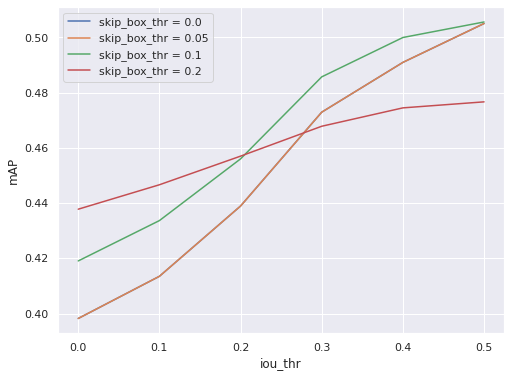

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, skip_box_thr in enumerate(skip_box_thrs):
    y = results[:, :, i].mean(axis=0)
    ax.plot(iou_thrs, y, label=f'skip_box_thr = {skip_box_thr}')
ax.set_ylabel('mAP')
ax.set_xlabel('iou_thr')
ax.legend()
plt.show()

In [132]:
# weighted box fusion by all classes
img_size = 1024
iou_thrs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
skip_box_thrs = [0.0, 0.05, 0.1, 0.2]

before = list()
f_map = list()

for fold, (evaluator, concat_df) in tqdm(enumerate(zip(evaluator_folds_1024, stack_folds_1024))):
    before_fold = list()
    for pred_col in [c for c in concat_df.columns if c != 'image_id']:
        pred_df = pd.DataFrame({'image_id': concat_df['image_id'], 'PredictionString': concat_df[pred_col]})
        before_fold += [evaluator.evaluate(pred_df).stats[0]]
    before += [before_fold]
    
    iou_map = list()
    for iou_thr in iou_thrs:
        sb_thr = list()
        for skip_box_thr in skip_box_thrs:
            ensemble_df = ensemble_by_all_classes(concat_df, img_size, iou_thr, skip_box_thr)
            sb_thr += [evaluator.evaluate(ensemble_df).stats[0]]
        iou_map += [sb_thr]
    f_map += [iou_map]

pickle.dump(np.array(f_map), open(str(base_dir / 'stack_wbf_all_1024.pkl'), 'wb'))    

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.82s).
Accumulating evaluation results...
DONE (t=0.35s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.595
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

In [133]:
results = pickle.load(open(str(base_dir / 'stack_wbf_all_1024.pkl'), 'rb'))

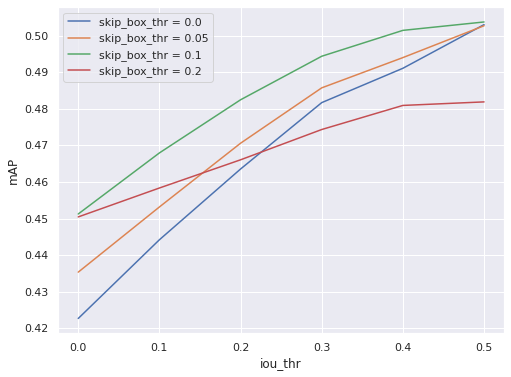

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, skip_box_thr in enumerate(skip_box_thrs):
    y = results[:, :, i].mean(axis=0)
    ax.plot(iou_thrs, y, label=f'skip_box_thr = {skip_box_thr}')
ax.set_ylabel('mAP')
ax.set_xlabel('iou_thr')
ax.legend()
plt.show()